# Setup

In [ ]:
!pip install opendatasets
!pip install google
!pip install clean-text
!pip install gibberish-detector
!pip install googletrans==3.1.0a0
!pip install torch==1.11.0
!pip install torchtext

import pandas as pd
import opendatasets as od
import numpy as np
from IPython.display import display
import seaborn as sns
from google.colab import files
from os import path
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from textblob import TextBlob
import re
from cleantext import clean
from traitlets.config import defaultdict
from gibberish_detector import detector
from googletrans import Translator
import torch
import torchtext

nltk.download('stopwords')
nltk.download('wordnet')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.3 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171048 sha256=db37d20d66ed28b6f790eb51cb8afebca5e3bec3e3c8f3b7cee9a0f391e385aa
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
print(torchtext.__version__)

0.15.1+cpu


In [ ]:
if not path.exists('./twitter_MBTI.csv'):
  files.upload()  # Upload your kaggle.json here

  !pip install -q kaggle
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 /root/.kaggle/kaggle.json

  !kaggle datasets download -d mazlumi/mbti-personality-type-twitter-dataset
  !unzip -q mbti-personality-type-twitter-dataset.zip
  !rm mbti-personality-type-twitter-dataset.zip

data = pd.read_csv('./twitter_MBTI.csv') 

Saving kaggle.json to kaggle.json
 77% 25.0M/32.7M [00:00<00:00, 121MB/s] 
100% 32.7M/32.7M [00:00<00:00, 123MB/s]


# Exploratory Data Analysis

In [ ]:
data.describe()

,Unnamed: 0
count,7811.000000
mean,3905.000000
std,2254.985809
min,0.000000
25%,1952.500000
50%,3905.000000
75%,5857.500000
max,7810.000000


In [ ]:
# Display the variables and data types in a table format
display(data.dtypes.to_frame().rename(columns={0: "Data Type"})) 

# Display dataset information
display(data.info())

# Display count of missing values in each variable
display(data.isnull().sum().to_frame().rename(columns={0: "Count of Missing Values"}))

# ---------------------
# The data contains 7811 rows and 3 columns. The labels for each column are the row value for each data (0-7810), text (tweet), and the personality label for the tweeter. There are no missing values in the data. 

,Data Type
Unnamed: 0,int64
text,object
label,object


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7811 entries, 0 to 7810
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7811 non-null   int64 
 1   text        7811 non-null   object
 2   label       7811 non-null   object
dtypes: int64(1), object(2)
memory usage: 183.2+ KB


None

,Count of Missing Values
Unnamed: 0,0
text,0
label,0


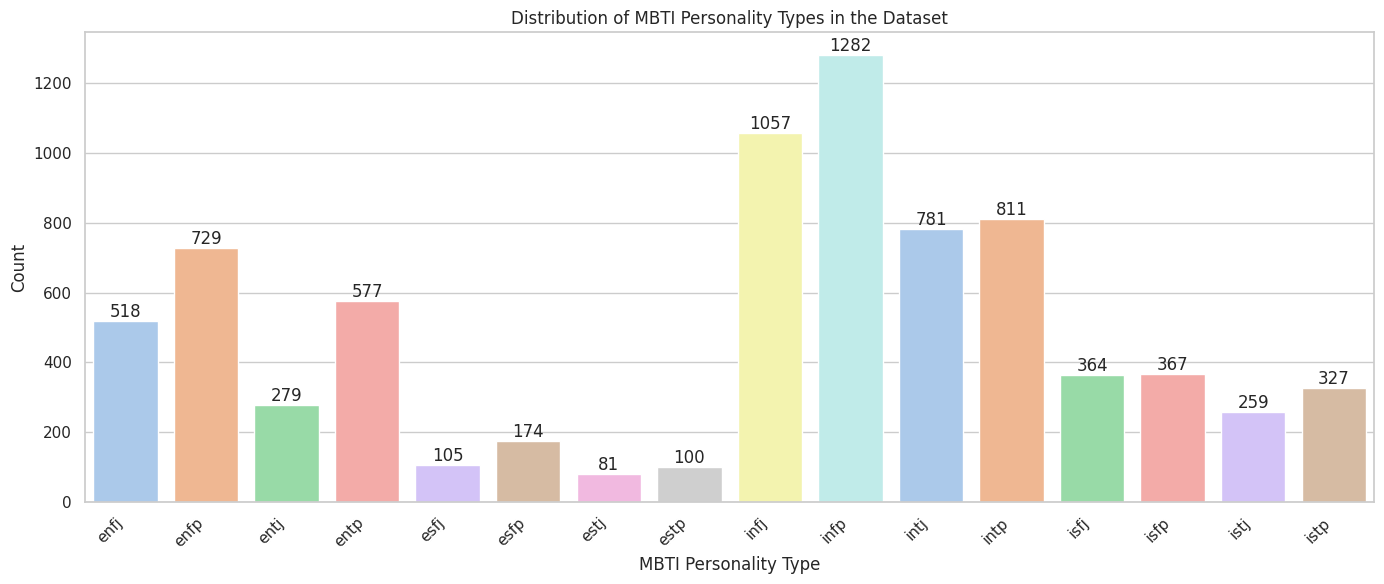

In [ ]:
# Set the style and color palette
sns.set(style="whitegrid", palette="pastel")

# Create count plot with interactive features
plt.figure(figsize=(14, 6))
ax = sns.countplot(data=data, x='label', order=sorted(data['label'].unique()), 
                   palette="pastel")
ax.set_title('Distribution of MBTI Personality Types in the Dataset')
ax.set_xlabel('MBTI Personality Type')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=12)
plt.tight_layout()

# Show interactive plot
plt.show()

# ---------------------
# Each row has a corresponding MBTI label for the tweeter 

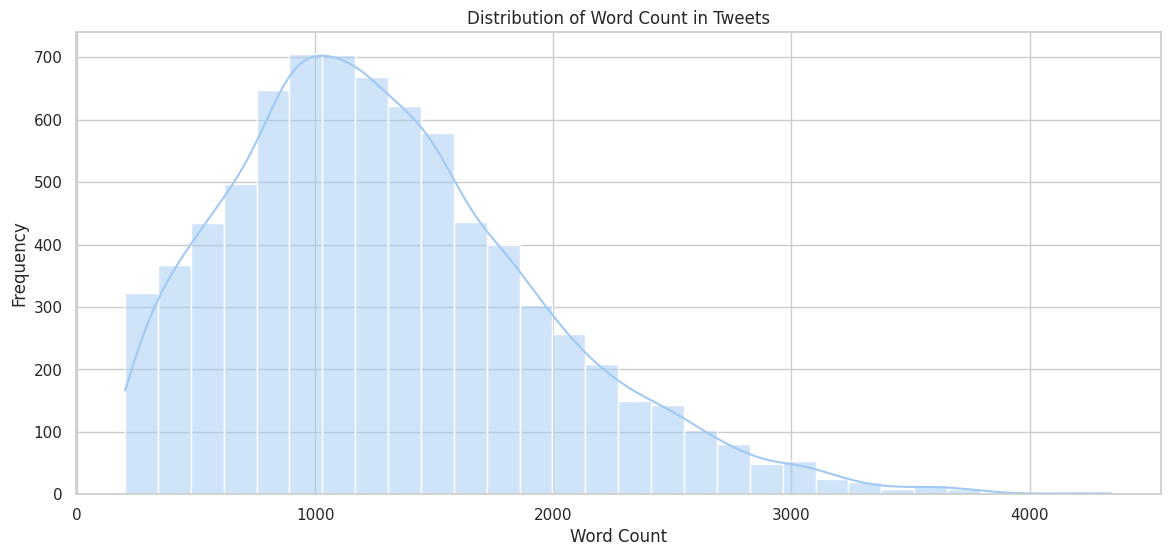

In [ ]:
# Plot distribution of word counts for each tweet
plt.figure(figsize=(14, 6))
sns.histplot(data=data['text'].apply(lambda x: len(x.split())), bins=30, kde=True)
plt.title('Distribution of Word Count in Tweets')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

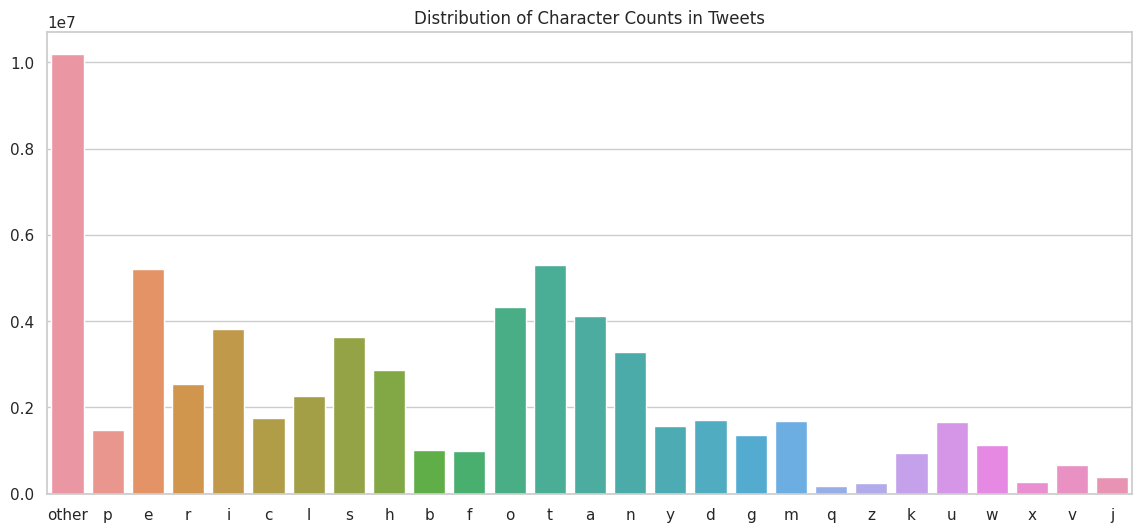

In [ ]:
chars = defaultdict(int)

def count_chars(tweet):
  for word in tweet.split():
    for char in word:
      char = char.lower()
      if char.isalpha() and char.isascii():
        chars[char]+=1
      else:
        chars['other']+=1

data.get("text").apply(count_chars)

plt.figure(figsize=(14, 6))
plt.title('Distribution of Character Counts in Tweets')
sns.barplot(x=list(chars.keys()), y=list(chars.values()))
plt.show()

# Other category includes everything that is not a letter in the English alphabet such as emojis, letters from foreign languages, and punctuation.

In [ ]:
# Detect Gibberish
if not path.exists('big.model'):
    files.upload()
Detector = detector.create_from_model('big.model')
def detect_gibberish_tweet(tweet):
  return Detector.calculate_probability_of_being_gibberish(tweet)

KeyboardInterrupt: ignored

In [ ]:
data_with_gibberish_label = data.assign(text_gibberish_probability=data.get("text").apply(detect_gibberish_tweet))
data_with_gibberish_label

,Unnamed: 0,text,label,text_gibberish_probability
0,0,@Pericles216 @HierBeforeTheAC @Sachinettiyil T...,intj,3.101766
1,1,@Hispanthicckk Being you makes you look cute||...,intj,3.091543
2,2,@Alshymi Les balles sont réelles et sont tirée...,intj,3.306833
3,3,"I'm like entp but idiotic|||Hey boy, do you wa...",intj,2.957641
4,4,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj,3.322980
...,...,...,...,...
7806,7806,"@sobsjjun God,,pls take care 😕|||@sobsjjun Hir...",intp,3.513421
7807,7807,@Ignis_02 wow last time i got intp https://t.c...,intp,3.324015
7808,7808,@akupilled A 100%|||@akupilled That SOMEONE wi...,entp,3.061010
7809,7809,If you’re #INTJ this one is for you | What is ...,infj,3.505624


In [ ]:
data_with_gibberish_label['text_gibberish_probability'].describe()

count    7811.000000
mean        3.277653
std         0.231429
min         2.681905
25%         3.110638
50%         3.238682
75%         3.409489
max         4.508320
Name: text_gibberish_probability, dtype: float64

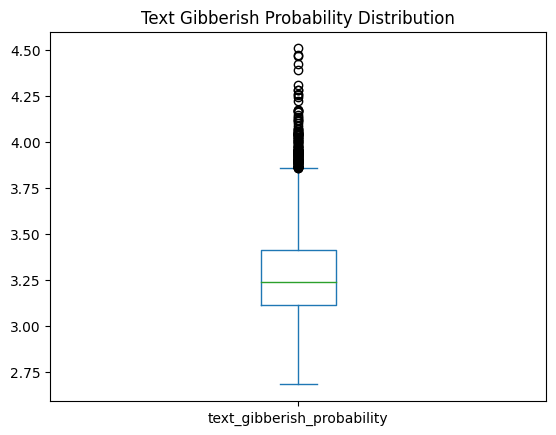

In [ ]:
data_with_gibberish_label['text_gibberish_probability'].plot(kind='box', title='Text Gibberish Probability Distribution')
plt.show()

In [ ]:
# detect language
def detect_translate_lang(text):
  translator = Translator()
  lang = translator.detect(text[:500]).lang
  return lang

In [ ]:
#translating tweets
data_with_lang = data.assign(lang=data.get("text").apply(detect_translate_lang))
data_with_lang.head()

KeyboardInterrupt: ignored

In [ ]:
#changes lists in the lang column to strings
def convert_to_string(text):
  if isinstance(text, list):
    text = ' '.join(text)
  return text

data_with_lang = data_with_lang.assign(lang=data_with_lang.get("lang").apply(convert_to_string))
data_with_lang.head()

,Unnamed: 0,text,label,lang
0,0,@Pericles216 @HierBeforeTheAC @Sachinettiyil T...,intj,en
1,1,@Hispanthicckk Being you makes you look cute||...,intj,en
2,2,@Alshymi Les balles sont réelles et sont tirée...,intj,fr
3,3,"I'm like entp but idiotic|||Hey boy, do you wa...",intj,en
4,4,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj,kri


In [ ]:
#number of tweets per language
grouped_lang = data_with_lang.groupby('lang').count()
grouped_lang.sort_values('text', ascending=False).head()

,Unnamed: 0,text,label
lang,,,
en,7265,7265,7265
tl,174,174,174
id,51,51,51
ko,43,43,43
zh-CN,23,23,23


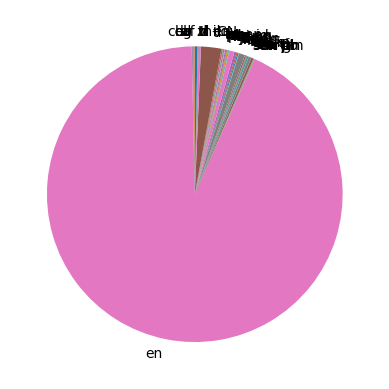

In [ ]:
#distribution of languages
y = grouped_lang.get('text').values
mylabels = grouped_lang.index

plt.pie(y, labels = mylabels, startangle = 90)
plt.show() 

# Data Cleaning


In [ ]:
# Helpful Links
# https://aronakhmad.medium.com/twitter-data-cleaning-using-python-db1ec2f28f08
# https://catriscode.com/2021/05/01/tweets-cleaning-with-python/
data = pd.read_csv('/content/twitter_MBTI.csv')

print('before cleaning:')
raw_data = repr(data.at[7806,'text'][:200]) # repr covert text to raw text which shows char like '\n'
print(raw_data)

for i in range(len(data['text'])):
  # remove @, #, web URL, newLine characters, special characters
  cleaned_text = re.sub(r'(@[A-Za-z0-9_]+)|(#[A-Za-z0-9_]+)|(http\S+)|(www.\S+)|(\n)|([^\w\s])','', data['text'][i])
  # replace multiple white spaces to single white space, then convert text to lowercase
  cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip().lower()
  data.at[i, 'text'] = cleaned_text

# removing emoji using cleantext.clean lib
data['text'] = data['text'].apply(lambda text: clean(text, no_emoji=True)) # Inefficient

print('after cleaning:')
raw_data = repr(data.at[7806,'text'][:200])
print(raw_data)
#display(data.loc[0]['text']) # After
data

before cleaning:
'@sobsjjun God,,pls take care 😕|||@sobsjjun Hiro emergency room???? Are you okay wait|||@_dafahoe_ Zeharrrrrrr😭😭😭😭😭😭😭😭|||@txtlomlsss @YE0NYANG OH MY GOD thats 💔|||@YE0NYANG @txtlomlsss DID I LIE|||@soo'
after cleaning:
'godpls take care hiro emergency room are you okay wait zeharrrrrrr oh my god thats did i lie i knownano hsoule grandma r so cutemy whole tl just 4 oomfs doing sum shit but i love it is this u plus i t'


,Unnamed: 0,text,label
0,0,the pope is infallible this is a catholic dogm...,intj
1,1,being you makes you look cute on because then ...,intj
2,2,les balles sont reelles et sont tirees tres ra...,intj
3,3,im like entp but idiotichey boy do you want to...,intj
4,4,give it to he has pica since childhood say qub...,intj
...,...,...,...
7806,7806,godpls take care hiro emergency room are you o...,intp
7807,7807,wow last time i got intp i think u upset the f...,intp
7808,7808,a 100 that someone will get his ass kicked so ...,entp
7809,7809,if youre this one is for you what is never fun...,infj


In [ ]:
data = data[data['text'].apply(detect_translate_lang)=='en'] # Strip the text of all foreign language. !Takes forever!
data.head()

In [ ]:
data.head()

NameError: ignored

# Preprocessing

### Tokenization

In [ ]:
nltk.download('punkt')
data['text_tokenized'] = data['text'].apply(lambda x: word_tokenize(x))

In [ ]:
data.head()

### Stopword removal


In [ ]:
stop_words = set(stopwords.words('english'))

# Iterate over each row and remove stop words from tokenized text
for index, row in data.iterrows():
    text_tokens = row['text_tokenized']
    filtered_tokens = list(filter(lambda token: token not in stop_words, text_tokens))
    data.at[index, 'text_tokenized'] = filtered_tokens

In [ ]:
data.head()

### Lemmatization

In [ ]:
# Initialize the Lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

data['text_tokenized_lemmatized'] = data['text_tokenized'].apply(lemmatize_text)

In [ ]:
data.head()

## Preprocess with (Sentiment Analysis with Pytorch by Gal Hever)

In [ ]:
# char_based = True
# if char_based:
#     tokenizer = lambda s: list(s) # char-based
# else:
#     tokenizer = lambda s: s.split() # word-based
#     Text = data.Field(preprocessing=cleanup_text, tokenize=tokenizer, batch_first=True,\
#                       include_lengths=True, fix_length=max_document_length)Label = data.Field(sequential=False,\
#                       use_vocab=False, pad_token=None, unk_token=None)

### Data Cleaning 

In [ ]:
def cleanup_text(texts):
    cleaned_text = []
    # removing emoji using cleantext.clean lib. 
    #Note: I think it also cleaned extra white spaces and upperCase. Need double check
    text = clean(text, no_emoji=True) # Inefficient
    # remove @, #, web URL, newLine characters, special characters
    text = re.sub(r'(@[A-Za-z0-9_]+)|(#[A-Za-z0-9_]+)|\
    (http\S+)|(www.\S+)|(\n)|([^\w\s])','', texts)

    cleaned_text.append(text)
    return cleaned_text

In [ ]:
from torchtext.legacy import data
Text = torchtext.legacy.data.Field(preprocessing=cleanup_text, tokenize=tokenizer, batch_first=True,\
                       include_lengths=True, fix_length=max_document_length)
Label = torchtext.legacy.data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)

ModuleNotFoundError: ignored

In [ ]:

print(torchtext.__version__)

0.15.1+cpu


# Preprocessing with custom dataset (Ignore the below, failing approach)


In [ ]:
# np.loadtxt('/content/twitter_MBTI.csv', delimiter=',', dtype=str)
pd.read_csv('/content/twitter_MBTI.csv').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7811 entries, 0 to 7810
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7811 non-null   int64 
 1   text        7811 non-null   object
 2   label       7811 non-null   object
dtypes: int64(1), object(2)
memory usage: 183.2+ KB


In [ ]:
dt = np.dtype([('Unnamed: 0', "str"), ("text", str), ('label', str)])
#np.loadtxt('/content/twitter_MBTI.csv', delimiter=',', dtype=str)
# df = pd.read_csv('/content/twitter_MBTI.csv', dtype={'Unnamed: 0': str, 'text': str, 'label': str})
# with open('/content/twitter_MBTI.csv', 'r') as f:
#     for i in range(15):
#         line = f.readline()
#         print('line', i, line)
print(torchtext.__version__)

0.15.1+cpu


In [ ]:
import torchvision
from torch.utils.data import Dataset, DataLoader

In [ ]:
class MBTIDataset(Dataset):

  def __init__(self):
    df = pd.read_csv('/content/twitter_MBTI.csv', dtype=str)
    self.x = torch.from_numpy(df['text'].values.astype(str))
    self.y = torch.from_numpy(df['label'].values.astype(str))
    self.n_samples = len(df)
  def __getitem__(self, index):
    return self.x[index], self.y[index]
  def __len__(self):
    return self.n_samples

dataset = MBTIDataset()
dataloader = DataLoader(dataset=dataset, batch_size=4, shuffle=True, num_workers=2)

num_epochs = 2
total_samples = len(dataset)
n_iterations = math.ceil(total_samples/4)
print(total_samples, n_iterations)

for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(dataloader):
        # here: 178 samples, batch_size = 4, n_iters=178/4=44.5 -> 45 iterations
        if (i+1) % 5 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_iterations}, inputs {inputs.shape}')


TypeError: ignored

In [ ]:
from torchdata.datapipes.iter import IterableWrapper, FileOpener
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

datapipe = IterableWrapper(['/content/twitter_MBTI.csv'])
datapipe = FileOpener(datapipe, mode='b')
datapipe = datapipe.parse_csv(skip_lines=1)

for sample in datapipe:
     print(sample)
     break

['0', '@Pericles216 @HierBeforeTheAC @Sachinettiyil The Pope is infallible, this is a catholic dogma \n\nIt doesn’t mean the… https://t.co/qmt0ezk0Ey|||@HierBeforeTheAC @Pericles216 @Sachinettiyil And by perpetually it entails that the church herself can elect new po… https://t.co/OGTxKfUDHQ|||@HierBeforeTheAC @Pericles216 @Sachinettiyil You open the door to unironic nonsense when you believe this nonsense.… https://t.co/Y6OqVfVwuY|||@HierBeforeTheAC @Pericles216 @Sachinettiyil You don’t know your own faith lol you just tried to say that “perpetua… https://t.co/AUzB61Ap4H|||@HierBeforeTheAC @Pericles216 @Sachinettiyil That’s like me saying that I’m gonna give you a bike that will never b… https://t.co/KF7PpQwxaD|||@HierBeforeTheAC @Pericles216 @Sachinettiyil You have a dumb view of God’s preservation of the church. God doesn’t… https://t.co/16aNiNAwDa|||@HierBeforeTheAC @Pericles216 @Sachinettiyil It’s not heretical, all sedes do is take 2 quotes out of context from… https://t.co/yVquv

In [ ]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")
tokenizer('hey1234@@wtf  ! f  man')

['hey1234@@wtf', '!', 'f', 'man']